In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import rosen, rosen_der, rosen_hess

%matplotlib inline

## Cauchy point

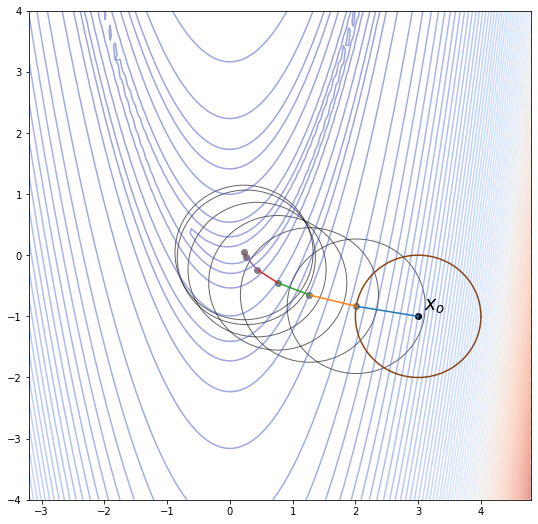

In [324]:
fig, ax = plt.subplots(figsize=(9, 9))

T0 = np.linspace(-3.2, 4.8, 100)
T1 = np.linspace(-4, 4, 100)
T0, T1 = np.meshgrid(T0, T1) # pairwise combinations of theta values
Z = rosen([T0, T1]) # Rosenbrock function
contour_levels = np.concatenate([np.array([3, 10, 30, 100, 200, 300, 500]), np.arange(1000, 79000, 1000)])
contour_plot = ax.contour(T0, T1, Z, levels=contour_levels, cmap='coolwarm', alpha=0.5) # contour plot of Rosenbrock function

init_point = np.array((3, -1)) # center of the initial trust region
init_radius = 1.
phis = np.arange(0, 6.28, 0.01) # angles for coordinate evaluations
circle_coords = (np.cos(phis)*init_radius+init_point[0], np.sin(phis)*init_radius+init_point[1])
ax.plot(*circle_coords, color='saddlebrown') # trust region
ax.scatter(*init_point, color='black') # center of the trust region
ax.text(init_point[0]+0.1, init_point[1]+0.1, '$x_o$', fontsize=19)



# here goes Cauchy point algorithm
def is_pos_def(x):
    '''Check if a matrix is positive definite'''
    return np.all(np.linalg.eigvals(x) > 0)


def cauchy_point(init_point: np.ndarray,
                 init_radius: float,
                 ) -> np.ndarray:
    x = init_point
    radius = init_radius
    
    n_iter = 0
    gain = 999
    while n_iter <= 5 and gain > 0.001:
        n_iter += 1
        f = rosen(x)
        f_derivative = rosen_der(x)
        f_hessian = rosen_hess(x)
        f_derivative_norm = np.linalg.norm(f_derivative)
        p_s = -radius*f_derivative/f_derivative_norm
        
        if is_pos_def(f_hessian):
            tau = f_derivative_norm**3/(radius*(f_derivative @ f_hessian @ f_derivative))
            if tau > 1:
                tau = 1
        else:
            tau = 1
        
        p_c = p_s*tau
        phi_new = rosen(x) + np.dot(f_derivative, p_c) + (p_c @ f_hessian @ p_c)/2 # modeled new point value of a function
        x_new = x + p_c
        f_new = rosen(x_new) # actial new point value of a function
        rho = (f - f_new)/(f - phi_new) # rate between actual and modeled reduction
        if rho < 0.25:
            radius = 0.25*np.linalg.norm(p_c)
            x_new = x
        elif rho > 0.75:
            radius = min(2*radius, 1.1)
        ax.plot(*zip(x, x_new)) # plot vector of change
        ax.scatter(*x_new, color='dimgrey', alpha=0.8) # center of new trust region
        draw_trust_region = plt.Circle((x_new[0], x_new[1]), radius=radius, fill=False, alpha=0.6) # contours of trust region
        ax.add_artist(draw_trust_region)
        
        x = x_new
        gain = f - rosen(x_new)
    return x

cauchy_point(np.array([3, -1]), 1)
plt.savefig('../../assets/images/optimization/cauchy_point.png', bbox_inches='tight');

## Dogleg 

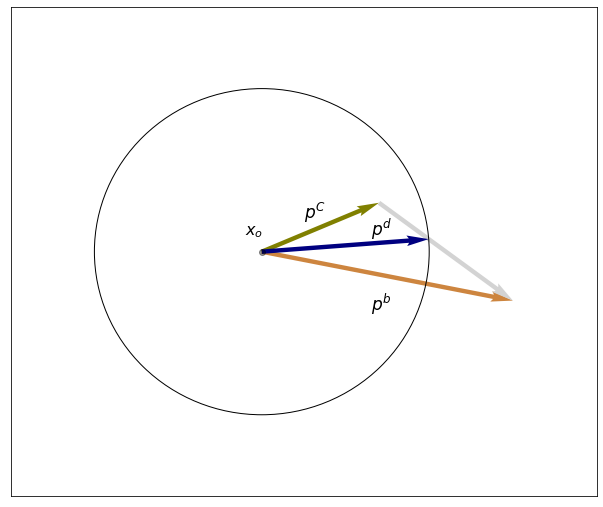

In [408]:
fig, ax = plt.subplots(figsize=(10.5, 9))
ax.set_xlim(-1.5, 2)
ax.set_ylim(-1.5, 1.5)

trust_region_dogleg = plt.Circle((0, 0), radius=1, fill=False)
ax.add_artist(trust_region_dogleg)
ax.scatter(0, 0, color='black', zorder=20, alpha=0.4)
ax.text(-0.1, 0.1, '$x_o$', fontsize=16)

ax.quiver([0, 0, 0.7, 0], # x origin
          [0, 0, 0.3, 0], # y origin
          [1.5, 0.7, 0.8, 0.997], # x vector
          [-0.3, 0.3, -0.6, 0.077], # y vector
          color=['peru', 'olive', 'lightgrey', 'navy'], linewidth=0.6,
          angles='xy', scale_units='xy', scale=1,
          headwidth=2.4)
ax.text(0.25, 0.2, '$p^C$', fontsize=17)
ax.text(0.65, -0.36, '$p^b$', fontsize=17)
ax.text(0.65, 0.1, '$p^d$', fontsize=17)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
plt.savefig('../../assets/images/optimization/dogleg.png', bbox_inches='tight');

pB = np.array([1.5, -0.3])
pU = np.array([0.7, 0.3])

pB_pU = pB - pU
dot_pB_pU = np.dot(pB_pU, pB_pU)
dot_pU = np.dot(pU, pU)
dot_pU_pB_pU = np.dot(pU, pB_pU)
fact = dot_pU_pB_pU**2 - dot_pB_pU * (dot_pU - trust_radius**2)
tau = (-dot_pU_pB_pU + np.sqrt(fact)) / dot_pB_pU
#print(pU + tau * pB_pU)